# GunPoint DATASET

Demo for Beggel's ADSL algorithm implementation in pytorch 

In [2]:
import pandas as pd

import os 
os.chdir('/home/ludovicobartoli/Documents/Shapelets')

import numpy as np
import random
import torch
from torch import tensor

from tslearn.datasets import CachedDatasets, UCR_UEA_datasets
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesScalerMeanVariance

from src.preprocessing_anomaly import preprocessing_anomaly
from src.SVDD.SVDD import SVDD
from src.util import Scaler, euclidean_distance_shifted, length_normalized_distance, max_corr, get_weights_via_kmeans, mean_shift
from src.learning.learningextractor import LearningShapelets 
from src.learning.similarityloss import DiscrepancySimilarity, CorrelationSimilairty
from src.searching.bruteforce_multivariate import Bruteforce_extractor_mv, Candidateset
from src.searching.RLS import RLS_extractor, RLS_candidateset

from sklearn.metrics import balanced_accuracy_score, roc_auc_score, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.svm import OneClassSVM

import matplotlib.pyplot as plt
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"


/opt/anaconda3/envs/ludo_env/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set up the dataset

### Read the data

In [3]:
data_name = "GunPoint"
X_train = np.load(f'demo/data/{data_name}_train.npy')
y_train = np.load(f'demo/data/{data_name}_train_labels.npy')
X_test = np.load(f'demo/data/{data_name}_test.npy')
y_test = np.load(f'demo/data/{data_name}_test_labeles.npy')

print(f'Shape of training data: {X_train.shape}')
print(f'Shape of test data: {X_test.shape}')
print(f'The different classes: {set(y_train)}')

Shape of training data: (50, 150, 1)
Shape of test data: (150, 150, 1)
The different classes: {1, 2}


### Preprocessing

In [4]:
X_total = np.concatenate((X_train, X_test), axis=0)
y_total = np.concatenate((y_train, y_test), axis=0)
print(f'Shape of the total data: {X_total.shape}')

#### check if one class is predominant
obs_perclass = [len(y_total[y_total==i]) for i in set(y_total)]
print(f'Number of total samples in each class: {obs_perclass}')

Shape of the total data: (200, 150, 1)
Number of total samples in each class: [100, 100]


Plot one sample per class:

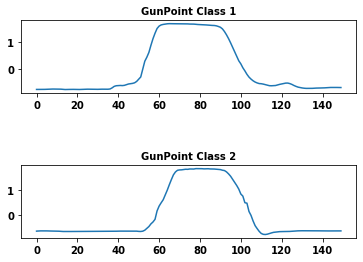

In [5]:
n_class = len(obs_perclass)
fig, ax = plt.subplots(n_class,)

# NOTE: modify if the labels start from 0 or 1
for i in range(n_class):
    ts = X_train[y_train==i+1][0,:,0]
    ax[i].set_title(f'{data_name} Class {i+1}', fontsize=10, fontweight="bold")
    ax[i].plot(ts)
plt.subplots_adjust(hspace=1)
plt.show()
plt.show()

#### Create anomaly detection dataset:

In [6]:
normal_class = 1 # choose the normal class
normal_prop = 0.8 # proportion of normal samples that go in train set
alpha = 0.05 # proportion of anomalies wrt normal 
valid_prop = 0.3
X_train_anomaly, y_train_anomaly, X_test_anomaly, y_test_anomaly, X_valid_anomaly, y_valid_anomaly = preprocessing_anomaly(X_train, y_train, X_test, y_test, alpha=alpha, normal_class=normal_class, normal_prop=normal_prop, valid_prop=valid_prop)


Get statistics of the anomaly detection dataset:

In [7]:
N, Q, n_channels = X_train_anomaly.shape
print(f'{data_name} dataset')
print(f'number train ts is {N}, each of length {Q}')
print(f'They belong to two possible classes: {set(y_train_anomaly)}')
print('number test ts', len(X_test_anomaly))
print('number of normal train series:', len(y_train_anomaly[y_train_anomaly==1]))
print('number of anomalous train series:', len(y_train_anomaly[y_train_anomaly==-1]))
print('number of normal test series:', len(y_test_anomaly[y_test_anomaly==1]))
print('number of anomalous test series:', len(y_test_anomaly[y_test_anomaly==-1]))
print('number of normal valid series:', len(y_valid_anomaly[y_valid_anomaly==1]))
print('number of anomalous valid series:', len(y_valid_anomaly[y_valid_anomaly==-1]))

GunPoint dataset
number train ts is 84, each of length 150
They belong to two possible classes: {1, -1}
number test ts 81
number of normal train series: 80
number of anomalous train series: 4
number of normal test series: 12
number of anomalous test series: 69
number of normal valid series: 8
number of anomalous valid series: 27


#### Normalize:

In [8]:
# normalize the time series
# as in the tutorial https://tslearn.readthedocs.io/en/stable/auto_examples/classification/plot_shapelets.html#sphx-glr-auto-examples-classification-plot-shapelets-py
scaler = TimeSeriesScalerMinMax()
X_train_anomaly = scaler.fit_transform(X_train_anomaly)
X_test_anomaly = scaler.fit_transform(X_test_anomaly)
X_valid_anomaly = scaler.fit_transform(X_valid_anomaly)

#### Plot train set

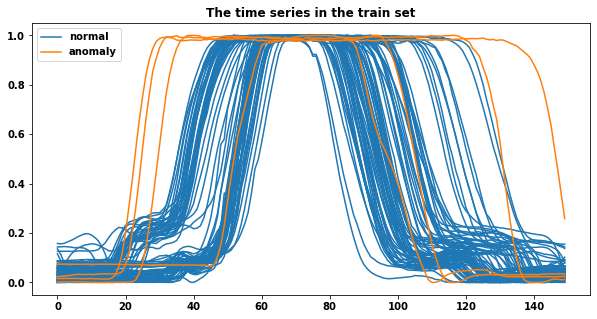

In [9]:
plt.figure(figsize=(10, 5))
for i in range(len(X_train_anomaly[y_train_anomaly==1][:,:,0])):
    ts = X_train_anomaly[y_train_anomaly==1][i,:,0]
    plt.plot(range(len(ts)), ts, c='tab:blue', label='normal' if i==0 else None)
for i in range(len(X_train_anomaly[y_train_anomaly==-1][:,:,0])):
    ts = X_train_anomaly[y_train_anomaly==-1][i,:,0]
    plt.plot(range(len(ts)), ts, c='tab:orange', label='anomaly' if i==0 else None)
plt.legend()
plt.title('The time series in the train set', fontweight="bold")
plt.show()


## BF algorithm:

In [14]:
extractor = Bruteforce_extractor_mv(train_data=X_train_anomaly, test_data=X_test_anomaly)

K_star = 0.02 # number of shapelets in proportion to length of time series
L_star = 0.2 # length of shapelets in proportion to length of time series
L = round(L_star * Q)
K = round(K_star * Q)

# REVERSE indicates whether the extracted shapelets are the furthest (True) or the nearest (False) to the majority of the time series
reverse = False
corr_threshold = 0.8
pos_boundary = None
# shapelets = extractor.extract_shapelets(K_star, L_star, pos_boundary=pos_boundary, corr_threshold=corr_threshold, reverse=reverse, sample_size=3000)

# S = shapelets.sequences
# np.save(f'../Results/GunPoint/s_reverse={reverse}pos_boundary={pos_boundary}_corr_threshold={corr_threshold}', S)
# or load the results
S = np.load(f'results/{data_name}/s_reverse={reverse}_L={L}_K={K}.npy')
extractor.shapelets = Candidateset()
extractor.shapelets.sequences = S

Plot the shapelets:


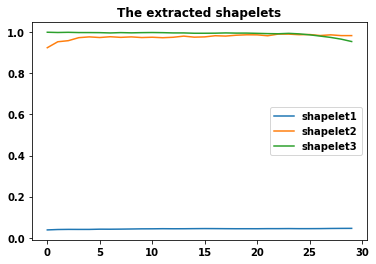

In [15]:
channel = 0
plt.figure()
for i in range(K):
    shap = S[i,:,channel]
    plt.plot(shap, label=f'shapelet{i+1}')
plt.legend()
plt.title('The extracted shapelets', fontweight="bold")
plt.show()

Type and shape of transformed train data <class 'numpy.ndarray'> (84, 3)
Type and shape of transformed test data <class 'numpy.ndarray'> (81, 3)
Test balanced accuracy: 0.4746376811594203
Test AUC: 0.4528985507246377
Test F1 score: 0.20253164556962025


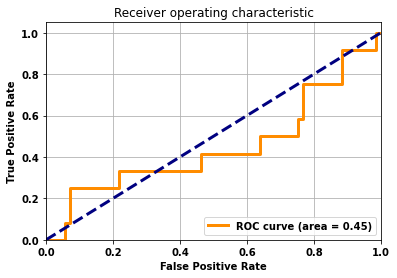

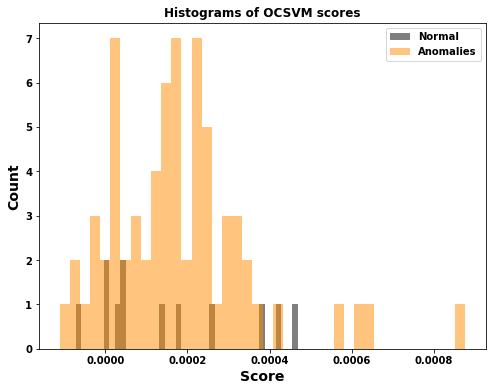

In [16]:
# transform both train and test 
X_train_transform, X_test_transform = extractor.transform()
print('Type and shape of transformed train data', type(X_train_transform),  X_train_transform.shape)
print('Type and shape of transformed test data', type(X_test_transform),  X_test_transform.shape)

X_anomaly = X_test_transform[y_test_anomaly==-1]
X_normal = X_test_transform[y_test_anomaly==1]
X_anomaly = np.mean(X_anomaly, axis=0)
X_normal = np.mean(X_normal, axis=0)

ocsvm = OneClassSVM(nu=alpha, kernel='linear')

# fit the model
ocsvm.fit(X_train_transform)

# BALANCED ACCURACY
y_test_predict = ocsvm.predict(X_test_transform)
test_ba = balanced_accuracy_score(y_test_anomaly, y_test_predict)
print("Test balanced accuracy:", test_ba)

# AUC
y_test_scores = ocsvm.decision_function(X_test_transform)
fpr, tpr, _ = roc_curve(y_test_anomaly, -y_test_scores, pos_label=-1)
auc_test = auc(fpr, tpr)
print("Test AUC:", auc_test)

# F1 score
f1_test = f1_score(y_test_anomaly, y_test_predict, pos_label=-1)
print("Test F1 score:", f1_test)


# ROC curve
fpr, tpr, _ = roc_curve(y_test_anomaly, y_test_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=3, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=3, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# OVERLAPPING HISTOGRAMS PLOT of SVDD scores (test data)

plt.figure(figsize=(8,6))
plt.hist(y_test_scores[y_test_anomaly==1], bins=40, alpha=0.5, label="Normal", color='black')
plt.hist(y_test_scores[y_test_anomaly==-1], bins=40, alpha=0.5, label="Anomalies", color='darkorange')

plt.xlabel("Score", size=14)
plt.ylabel("Count", size=14)
plt.title("Histograms of OCSVM scores", fontweight="bold")
plt.legend(loc='upper right')
plt.show()

## ADSL (learning shapelets):

Implementation of Beggel's "Anomaly Detection algorithm with Shapelet-based Feature Learning" (ADSL).
K Shapelets of length L are parametrized; given the shapelet transform of a multivariate time series $t^i$ with C channels:
\begin{equation}
x^i = (x^i_1, \dots, x^i_K), \enspace x^i_k = min_{l=1,\dots, J} \left\lVert s^k  - t^i_{l, l+L}\right\rVert^2
\end{equation}

Define $l(x^i) = \sum_{k=1}^K (x^i_k)^2$ the norm of the transform vector in $R^K$

Given a batch of N time series, the loss to minimize is:
\begin{equation}
L_S(t^1,\dots,t^N) = \frac{1}{N} (\sum_{i=1}^N max(0, l(x^i) - R^2) C +  \sum_{i=1}^N l(x^i))
\end{equation}
where R is the radius of the last update of the SVDD boundary, C is the hyperparameter of the SVDD.

#### K-Means Inizialization 

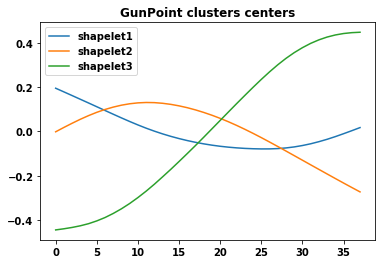

The shape of cluster centers is torch.Size([3, 1, 38])


In [20]:
K_star =  0.02
L_star = 0.25
L = round(L_star*Q)
K = round(K_star*Q)
n_segments = N*(Q-K+1)
clusters_centers = get_weights_via_kmeans(X_train_anomaly, len_shapelets=L, num_shapelets=K, n_segments=n_segments)


# np.save(f'demo/data/{data_name}_clusters_K={K}_L={L}', clusters_centers)

# plot the mean-shifted clusters' centers
S_init = clusters_centers - np.mean(clusters_centers, axis=1, keepdims=True)

plt.figure()
for i in range(len(S_init)):
    shap = S_init[i,:,]
    plt.plot(shap, label=f'shapelet{i+1}')
plt.legend()
plt.title(f'{data_name} clusters centers', fontweight="bold")
plt.show()

dtype = torch.float
clusters_centers = torch.tensor(clusters_centers.transpose(0,2,1), dtype=dtype)
clusters_centers = clusters_centers - torch.mean(clusters_centers, dim=2, keepdim=True)

print(f'The shape of cluster centers is {clusters_centers.shape}') 

### TRAINING

In [31]:
n_epoch_steps = 200
n_epochs = 1
# total epochs = n_epoch_steps * n_epochs
batch_size = N
lr = 1e-2
# Input shape must be a pytorch TENSOR with shape (n_samples, in_channels, len_ts)
X_train_tensor = tensor(X_train_anomaly, dtype=torch.float).contiguous().transpose(1,2)
aucs = []
bas = []
f1s = []
nu = 0.15
C = 1 / (N * nu)
l1 = 1
loss_sim = DiscrepancySimilarity()
extractor = LearningShapelets(len_shapelets=L, num_shapelets=K, in_channels=n_channels, C=C, verbose=1, to_cuda=False, l1=l1, loss_sim=loss_sim)
extractor.set_shapelet_weights(clusters_centers)
optimizer = torch.optim.Adagrad(extractor.model.parameters(), lr=lr)
extractor.set_optimizer(optimizer)

extractor.compute_radius(X_train_tensor, tol=1e-7)

losses = []
loss_sim = []
for epoch in range(n_epoch_steps):
    print(f'Epoch: {epoch}')
    extractor.compute_radius(X_train_tensor, tol=1e-7)
    print('radius', extractor.loss_func.get_radius())
    current_loss_dist, current_loss_sim =  extractor.fit(X_train_tensor, epochs=n_epochs, batch_size=batch_size)
    # current_loss_dist =  extractor.fit(X_train_tensor, epochs=n_epochs, batch_size=batch_size)
    losses += [current_loss_dist]
    loss_sim += [current_loss_sim]
    print(f'Loss sim: {current_loss_sim}')

Epoch: 0
radius 0.48530582


Loss dist: 0.4524841606616974: 100%|██████████| 1/1 [00:00<00:00, 12.44it/s]

Loss sim: [0.19013404846191406]
Epoch: 1


radius 0.48198798


Loss dist: 0.45825719833374023: 100%|██████████| 1/1 [00:00<00:00, 12.43it/s]


Loss sim: [0.1912688910961151]
Epoch: 2
radius 0.47608888


Loss dist: 0.44997403025627136: 100%|██████████| 1/1 [00:00<00:00, 12.36it/s]

Loss sim: [0.18611906468868256]
Epoch: 3


radius 0.4855868


Loss dist: 0.4385722577571869: 100%|██████████| 1/1 [00:00<00:00, 12.39it/s]


Loss sim: [0.18394558131694794]
Epoch: 4
radius 0.46548784


Loss dist: 0.44926249980926514: 100%|██████████| 1/1 [00:00<00:00, 271.93it/s]


Loss sim: [0.1827167272567749]
Epoch: 5
radius 0.4799725


Loss dist: 0.4362100660800934: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


Loss sim: [0.18071529269218445]
Epoch: 6
radius 0.47161177


Loss dist: 0.43979597091674805: 100%|██████████| 1/1 [00:00<00:00, 245.12it/s]


Loss sim: [0.17969167232513428]
Epoch: 7
radius 0.4685388


Loss dist: 0.4395035207271576: 100%|██████████| 1/1 [00:00<00:00, 12.38it/s]


Loss sim: [0.17886114120483398]
Epoch: 8
radius 0.46753448


Loss dist: 0.438518762588501: 100%|██████████| 1/1 [00:00<00:00, 12.16it/s]

Loss sim: [0.17731082439422607]
Epoch: 9


radius 0.4656122


Loss dist: 0.43798819184303284: 100%|██████████| 1/1 [00:00<00:00, 292.88it/s]


Loss sim: [0.17623139917850494]
Epoch: 10
radius 0.4654277


Loss dist: 0.4369082450866699: 100%|██████████| 1/1 [00:00<00:00, 304.27it/s]


Loss sim: [0.17538012564182281]
Epoch: 11
radius 0.4631112


Loss dist: 0.43718400597572327: 100%|██████████| 1/1 [00:00<00:00, 222.77it/s]


Loss sim: [0.17476515471935272]
Epoch: 12
radius 0.46908817


Loss dist: 0.43224647641181946: 100%|██████████| 1/1 [00:00<00:00, 311.77it/s]


Loss sim: [0.1739259958267212]
Epoch: 13
radius 0.4650887


Loss dist: 0.4332468509674072: 100%|██████████| 1/1 [00:00<00:00, 305.11it/s]


Loss sim: [0.17437639832496643]
Epoch: 14
radius 0.46921456


Loss dist: 0.4299463927745819: 100%|██████████| 1/1 [00:00<00:00, 12.32it/s]

Loss sim: [0.1730707585811615]
Epoch: 15


radius 0.46737552


Loss dist: 0.4291292428970337: 100%|██████████| 1/1 [00:00<00:00, 12.47it/s]

Loss sim: [0.17344029247760773]
Epoch: 16


radius 0.46632183


Loss dist: 0.42886391282081604: 100%|██████████| 1/1 [00:00<00:00, 12.39it/s]

Loss sim: [0.17218665778636932]
Epoch: 17


radius 0.45992598


Loss dist: 0.43112412095069885: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]

Loss sim: [0.17161661386489868]
Epoch: 18


radius 0.45617798


Loss dist: 0.4317179322242737: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]

Loss sim: [0.17047853767871857]
Epoch: 19


radius 0.45669752


Loss dist: 0.42879462242126465: 100%|██████████| 1/1 [00:00<00:00, 12.15it/s]

Loss sim: [0.1694403886795044]
Epoch: 20


radius 0.45299354


Loss dist: 0.428164541721344: 100%|██████████| 1/1 [00:00<00:00, 245.17it/s]


Loss sim: [0.16835670173168182]
Epoch: 21
radius 0.4442929


Loss dist: 0.43114393949508667: 100%|██████████| 1/1 [00:00<00:00, 12.42it/s]


Loss sim: [0.16793414950370789]
Epoch: 22
radius 0.44247183


Loss dist: 0.42833274602890015: 100%|██████████| 1/1 [00:00<00:00, 12.56it/s]


Loss sim: [0.17040756344795227]
Epoch: 23
radius 0.441586


Loss dist: 0.42690181732177734: 100%|██████████| 1/1 [00:00<00:00, 297.43it/s]


Loss sim: [0.16608847677707672]
Epoch: 24
radius 0.43484098


Loss dist: 0.4282436668872833: 100%|██████████| 1/1 [00:00<00:00, 301.75it/s]


Loss sim: [0.16589246690273285]
Epoch: 25
radius 0.43635085


Loss dist: 0.4241456985473633: 100%|██████████| 1/1 [00:00<00:00, 295.81it/s]


Loss sim: [0.1658981889486313]
Epoch: 26
radius 0.43033105


Loss dist: 0.4271336495876312: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s]


Loss sim: [0.16543637216091156]
Epoch: 27
radius 0.42896467


Loss dist: 0.4260265827178955: 100%|██████████| 1/1 [00:00<00:00, 205.17it/s]


Loss sim: [0.16487161815166473]
Epoch: 28
radius 0.42725405


Loss dist: 0.42535972595214844: 100%|██████████| 1/1 [00:00<00:00, 216.59it/s]


Loss sim: [0.16499736905097961]
Epoch: 29
radius 0.42295185


Loss dist: 0.42636623978614807: 100%|██████████| 1/1 [00:00<00:00, 231.73it/s]


Loss sim: [0.1646074801683426]
Epoch: 30
radius 0.4211194


Loss dist: 0.4255421757698059: 100%|██████████| 1/1 [00:00<00:00, 12.37it/s]


Loss sim: [0.16445529460906982]
Epoch: 31
radius 0.41978464


Loss dist: 0.4250738024711609: 100%|██████████| 1/1 [00:00<00:00, 12.36it/s]


Loss sim: [0.1640617549419403]
Epoch: 32
radius 0.41805443


Loss dist: 0.42492973804473877: 100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


Loss sim: [0.16384439170360565]
Epoch: 33
radius 0.41624174


Loss dist: 0.42452067136764526: 100%|██████████| 1/1 [00:00<00:00, 237.91it/s]


Loss sim: [0.16357240080833435]
Epoch: 34
radius 0.41446415


Loss dist: 0.4241947531700134: 100%|██████████| 1/1 [00:00<00:00, 301.94it/s]


Loss sim: [0.16286171972751617]
Epoch: 35
radius 0.41353184


Loss dist: 0.42299720644950867: 100%|██████████| 1/1 [00:00<00:00, 12.45it/s]


Loss sim: [0.16238181293010712]
Epoch: 36
radius 0.4102079


Loss dist: 0.4202457070350647: 100%|██████████| 1/1 [00:00<00:00, 12.45it/s]

Loss sim: [0.16205304861068726]
Epoch: 37


radius 0.4050434


Loss dist: 0.417103111743927: 100%|██████████| 1/1 [00:00<00:00, 12.41it/s]

Loss sim: [0.16165994107723236]
Epoch: 38


radius 0.4051906


Loss dist: 0.4074523448944092: 100%|██████████| 1/1 [00:00<00:00, 12.12it/s]

Loss sim: [0.161559596657753]
Epoch: 39


radius 0.40588647


Loss dist: 0.4012744724750519: 100%|██████████| 1/1 [00:00<00:00, 12.45it/s]

Loss sim: [0.1615075021982193]
Epoch: 40


radius 0.4057608


Loss dist: 0.39747145771980286: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s]

Loss sim: [0.1607782244682312]
Epoch: 41


radius 0.40659177


Loss dist: 0.39388707280158997: 100%|██████████| 1/1 [00:00<00:00, 12.37it/s]

Loss sim: [0.16007393598556519]
Epoch: 42


radius 0.40581584


Loss dist: 0.39211705327033997: 100%|██████████| 1/1 [00:00<00:00, 12.98it/s]

Loss sim: [0.1597956418991089]
Epoch: 43


radius 0.40481013


Loss dist: 0.39083948731422424: 100%|██████████| 1/1 [00:00<00:00, 12.45it/s]

Loss sim: [0.15898731350898743]
Epoch: 44


radius 0.40452278


Loss dist: 0.3893812596797943: 100%|██████████| 1/1 [00:00<00:00, 12.44it/s]

Loss sim: [0.15802830457687378]
Epoch: 45


radius 0.40577528


Loss dist: 0.3874247670173645: 100%|██████████| 1/1 [00:00<00:00, 12.44it/s]

Loss sim: [0.15689027309417725]
Epoch: 46


radius 0.40041026


Loss dist: 0.39038002490997314: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]

Loss sim: [0.15628278255462646]
Epoch: 47


radius 0.40564546


Loss dist: 0.38631361722946167: 100%|██████████| 1/1 [00:00<00:00, 270.27it/s]


Loss sim: [0.15553393959999084]
Epoch: 48
radius 0.4065767


Loss dist: 0.38523969054222107: 100%|██████████| 1/1 [00:00<00:00, 142.23it/s]


Loss sim: [0.15501919388771057]
Epoch: 49
radius 0.40579832


Loss dist: 0.38553711771965027: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]

Loss sim: [0.15448299050331116]
Epoch: 50


radius 0.40664792


Loss dist: 0.38458624482154846: 100%|██████████| 1/1 [00:00<00:00, 13.07it/s]

Loss sim: [0.15399335324764252]
Epoch: 51


radius 0.40573844


Loss dist: 0.38518980145454407: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s]

Loss sim: [0.1533491313457489]
Epoch: 52


radius 0.4079261


Loss dist: 0.383324533700943: 100%|██████████| 1/1 [00:00<00:00, 205.13it/s]


Loss sim: [0.15314458310604095]
Epoch: 53
radius 0.41954046


Loss dist: 0.3750118315219879: 100%|██████████| 1/1 [00:00<00:00, 12.45it/s]


Loss sim: [0.15296289324760437]
Epoch: 54
radius 0.40538517


Loss dist: 0.3846297860145569: 100%|██████████| 1/1 [00:00<00:00, 12.49it/s]


Loss sim: [0.1528775691986084]
Epoch: 55
radius 0.4077998


Loss dist: 0.3830450475215912: 100%|██████████| 1/1 [00:00<00:00, 12.41it/s]


Loss sim: [0.15243837237358093]
Epoch: 56
radius 0.40775302


Loss dist: 0.382992684841156: 100%|██████████| 1/1 [00:00<00:00, 12.37it/s]


Loss sim: [0.15227791666984558]
Epoch: 57
radius 0.42200455


Loss dist: 0.3731352388858795: 100%|██████████| 1/1 [00:00<00:00, 292.55it/s]


Loss sim: [0.15206341445446014]
Epoch: 58
radius 0.40534917


Loss dist: 0.3843437731266022: 100%|██████████| 1/1 [00:00<00:00, 305.51it/s]


Loss sim: [0.15228499472141266]
Epoch: 59
radius 0.4104927


Loss dist: 0.3809163272380829: 100%|██████████| 1/1 [00:00<00:00, 12.43it/s]


Loss sim: [0.1518966406583786]
Epoch: 60
radius 0.41018617


Loss dist: 0.3809753656387329: 100%|██████████| 1/1 [00:00<00:00, 12.38it/s]

Loss sim: [0.1519036442041397]
Epoch: 61


radius 0.4101022


Loss dist: 0.3810383677482605: 100%|██████████| 1/1 [00:00<00:00, 267.00it/s]


Loss sim: [0.15177854895591736]
Epoch: 62
radius 0.42213687


Loss dist: 0.3726973831653595: 100%|██████████| 1/1 [00:00<00:00, 12.45it/s]


Loss sim: [0.1516798436641693]
Epoch: 63
radius 0.4056606


Loss dist: 0.3838658928871155: 100%|██████████| 1/1 [00:00<00:00, 12.41it/s]


Loss sim: [0.15192434191703796]
Epoch: 64
radius 0.42263272


Loss dist: 0.372319757938385: 100%|██████████| 1/1 [00:00<00:00, 12.41it/s]


Loss sim: [0.15154485404491425]
Epoch: 65
radius 0.40597084


Loss dist: 0.38361024856567383: 100%|██████████| 1/1 [00:00<00:00, 308.65it/s]


Loss sim: [0.1517995297908783]
Epoch: 66
radius 0.40985984


Loss dist: 0.3811342120170593: 100%|██████████| 1/1 [00:00<00:00, 313.52it/s]


Loss sim: [0.15143431723117828]
Epoch: 67
radius 0.40942168


Loss dist: 0.38142168521881104: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


Loss sim: [0.1513889729976654]
Epoch: 68
radius 0.409448


Loss dist: 0.381392240524292: 100%|██████████| 1/1 [00:00<00:00, 12.44it/s]

Loss sim: [0.15134598314762115]
Epoch: 69


radius 0.40936762


Loss dist: 0.38143131136894226: 100%|██████████| 1/1 [00:00<00:00, 12.41it/s]

Loss sim: [0.15131370723247528]
Epoch: 70


radius 0.40935525


Loss dist: 0.38143274188041687: 100%|██████████| 1/1 [00:00<00:00, 12.25it/s]

Loss sim: [0.15127752721309662]
Epoch: 71


radius 0.40932733


Loss dist: 0.38144785165786743: 100%|██████████| 1/1 [00:00<00:00, 305.40it/s]


Loss sim: [0.15124550461769104]
Epoch: 72
radius 0.40931085


Loss dist: 0.3814534842967987: 100%|██████████| 1/1 [00:00<00:00, 12.30it/s]


Loss sim: [0.15121310949325562]
Epoch: 73
radius 0.4092991


Loss dist: 0.3814584016799927: 100%|██████████| 1/1 [00:00<00:00, 12.69it/s]


Loss sim: [0.15118277072906494]
Epoch: 74
radius 0.40928882


Loss dist: 0.38146573305130005: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s]


Loss sim: [0.15115393698215485]
Epoch: 75
radius 0.4092751


Loss dist: 0.38147836923599243: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


Loss sim: [0.1511269509792328]
Epoch: 76
radius 0.4092657


Loss dist: 0.3814861476421356: 100%|██████████| 1/1 [00:00<00:00, 12.08it/s]


Loss sim: [0.15110115706920624]
Epoch: 77
radius 0.40925318


Loss dist: 0.3814984858036041: 100%|██████████| 1/1 [00:00<00:00, 12.42it/s]


Loss sim: [0.15107667446136475]
Epoch: 78
radius 0.40924737


Loss dist: 0.38150471448898315: 100%|██████████| 1/1 [00:00<00:00, 176.57it/s]


Loss sim: [0.15105420351028442]
Epoch: 79
radius 0.40924534


Loss dist: 0.38150927424430847: 100%|██████████| 1/1 [00:00<00:00, 306.78it/s]


Loss sim: [0.1510336548089981]
Epoch: 80
radius 0.40923682


Loss dist: 0.3815186023712158: 100%|██████████| 1/1 [00:00<00:00, 285.35it/s]


Loss sim: [0.15101391077041626]
Epoch: 81
radius 0.40923044


Loss dist: 0.3815262019634247: 100%|██████████| 1/1 [00:00<00:00, 295.48it/s]


Loss sim: [0.15099464356899261]
Epoch: 82
radius 0.40922725


Loss dist: 0.3815320134162903: 100%|██████████| 1/1 [00:00<00:00, 294.63it/s]


Loss sim: [0.15097776055335999]
Epoch: 83
radius 0.40922496


Loss dist: 0.38154172897338867: 100%|██████████| 1/1 [00:00<00:00, 298.34it/s]


Loss sim: [0.1509605348110199]
Epoch: 84
radius 0.40921614


Loss dist: 0.381551057100296: 100%|██████████| 1/1 [00:00<00:00, 11.83it/s]


Loss sim: [0.1509438157081604]
Epoch: 85
radius 0.40920803


Loss dist: 0.3815624713897705: 100%|██████████| 1/1 [00:00<00:00, 12.48it/s]

Loss sim: [0.15092739462852478]
Epoch: 86


radius 0.40920416


Loss dist: 0.3815702795982361: 100%|██████████| 1/1 [00:00<00:00, 12.18it/s]


Loss sim: [0.15091204643249512]
Epoch: 87
radius 0.40920106


Loss dist: 0.3815814256668091: 100%|██████████| 1/1 [00:00<00:00, 294.42it/s]


Loss sim: [0.15089748799800873]
Epoch: 88
radius 0.40919143


Loss dist: 0.38159552216529846: 100%|██████████| 1/1 [00:00<00:00, 12.45it/s]


Loss sim: [0.15088364481925964]
Epoch: 89
radius 0.40918636


Loss dist: 0.38160255551338196: 100%|██████████| 1/1 [00:00<00:00, 209.90it/s]


Loss sim: [0.15087050199508667]
Epoch: 90
radius 0.40346882


Loss dist: 0.38572221994400024: 100%|██████████| 1/1 [00:00<00:00, 12.38it/s]


Loss sim: [0.15066905319690704]
Epoch: 91
radius 0.40778613


Loss dist: 0.3828873038291931: 100%|██████████| 1/1 [00:00<00:00, 12.39it/s]


Loss sim: [0.15045545995235443]
Epoch: 92
radius 0.4078135


Loss dist: 0.38289910554885864: 100%|██████████| 1/1 [00:00<00:00, 12.23it/s]


Loss sim: [0.15039698779582977]
Epoch: 93
radius 0.40663326


Loss dist: 0.38385871052742004: 100%|██████████| 1/1 [00:00<00:00, 12.23it/s]


Loss sim: [0.15012291073799133]
Epoch: 94
radius 0.4048501


Loss dist: 0.38523808121681213: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


Loss sim: [0.14963223040103912]
Epoch: 95
radius 0.40568352


Loss dist: 0.3847448229789734: 100%|██████████| 1/1 [00:00<00:00, 297.49it/s]


Loss sim: [0.14902949333190918]
Epoch: 96
radius 0.40546265


Loss dist: 0.3849904537200928: 100%|██████████| 1/1 [00:00<00:00, 12.45it/s]


Loss sim: [0.14864031970500946]
Epoch: 97
radius 0.40576363


Loss dist: 0.3848298490047455: 100%|██████████| 1/1 [00:00<00:00, 12.29it/s]


Loss sim: [0.14830413460731506]
Epoch: 98
radius 0.40487862


Loss dist: 0.3854609727859497: 100%|██████████| 1/1 [00:00<00:00, 12.36it/s]


Loss sim: [0.14763587713241577]
Epoch: 99
radius 0.4040166


Loss dist: 0.3861844837665558: 100%|██████████| 1/1 [00:00<00:00, 12.41it/s]


Loss sim: [0.14708544313907623]
Epoch: 100
radius 0.4035717


Loss dist: 0.38656532764434814: 100%|██████████| 1/1 [00:00<00:00, 12.41it/s]


Loss sim: [0.1468057930469513]
Epoch: 101
radius 0.40451148


Loss dist: 0.3860834836959839: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


Loss sim: [0.14653263986110687]
Epoch: 102
radius 0.403423


Loss dist: 0.3869323134422302: 100%|██████████| 1/1 [00:00<00:00, 247.00it/s]


Loss sim: [0.14617574214935303]
Epoch: 103
radius 0.40370405


Loss dist: 0.3868394196033478: 100%|██████████| 1/1 [00:00<00:00, 12.66it/s]


Loss sim: [0.14556890726089478]
Epoch: 104
radius 0.40327975


Loss dist: 0.38710078597068787: 100%|██████████| 1/1 [00:00<00:00, 12.42it/s]


Loss sim: [0.1447674036026001]
Epoch: 105
radius 0.40227354


Loss dist: 0.3877204656600952: 100%|██████████| 1/1 [00:00<00:00, 12.36it/s]


Loss sim: [0.14397859573364258]
Epoch: 106
radius 0.40159002


Loss dist: 0.3878503441810608: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]


Loss sim: [0.14313805103302002]
Epoch: 107
radius 0.40125805


Loss dist: 0.3880290687084198: 100%|██████████| 1/1 [00:00<00:00, 294.75it/s]


Loss sim: [0.14238686859607697]
Epoch: 108
radius 0.40094307


Loss dist: 0.3880261182785034: 100%|██████████| 1/1 [00:00<00:00, 296.92it/s]


Loss sim: [0.14175602793693542]
Epoch: 109
radius 0.42362988


Loss dist: 0.3720916211605072: 100%|██████████| 1/1 [00:00<00:00, 295.96it/s]


Loss sim: [0.14105841517448425]
Epoch: 110
radius 0.39833963


Loss dist: 0.38881543278694153: 100%|██████████| 1/1 [00:00<00:00, 12.24it/s]


Loss sim: [0.14067022502422333]
Epoch: 111
radius 0.40220213


Loss dist: 0.3863922953605652: 100%|██████████| 1/1 [00:00<00:00, 12.36it/s]


Loss sim: [0.13923856616020203]
Epoch: 112
radius 0.40180203


Loss dist: 0.38630905747413635: 100%|██████████| 1/1 [00:00<00:00, 12.24it/s]

Loss sim: [0.1385844200849533]
Epoch: 113


radius 0.40314585


Loss dist: 0.38545525074005127: 100%|██████████| 1/1 [00:00<00:00, 12.15it/s]


Loss sim: [0.13779957592487335]
Epoch: 114
radius 0.42749977


Loss dist: 0.36883997917175293: 100%|██████████| 1/1 [00:00<00:00, 12.43it/s]

Loss sim: [0.1372186243534088]
Epoch: 115


radius 0.39789745


Loss dist: 0.38861289620399475: 100%|██████████| 1/1 [00:00<00:00, 217.64it/s]


Loss sim: [0.1376757025718689]
Epoch: 116
radius 0.40318426


Loss dist: 0.3853118419647217: 100%|██████████| 1/1 [00:00<00:00, 216.09it/s]


Loss sim: [0.1369037628173828]
Epoch: 117
radius 0.40449917


Loss dist: 0.3846345543861389: 100%|██████████| 1/1 [00:00<00:00, 215.36it/s]


Loss sim: [0.13641628623008728]
Epoch: 118
radius 0.4039018


Loss dist: 0.3849969804286957: 100%|██████████| 1/1 [00:00<00:00, 12.37it/s]


Loss sim: [0.13634932041168213]
Epoch: 119
radius 0.4048831


Loss dist: 0.38446545600891113: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s]


Loss sim: [0.13611814379692078]
Epoch: 120
radius 0.40429628


Loss dist: 0.38482409715652466: 100%|██████████| 1/1 [00:00<00:00, 12.38it/s]


Loss sim: [0.1361062377691269]
Epoch: 121
radius 0.40412933


Loss dist: 0.38495200872421265: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


Loss sim: [0.13605765998363495]
Epoch: 122
radius 0.4041336


Loss dist: 0.38497528433799744: 100%|██████████| 1/1 [00:00<00:00, 12.40it/s]


Loss sim: [0.1359984427690506]
Epoch: 123
radius 0.40419495


Loss dist: 0.38496989011764526: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s]


Loss sim: [0.13594591617584229]
Epoch: 124
radius 0.40428278


Loss dist: 0.38494279980659485: 100%|██████████| 1/1 [00:00<00:00, 235.69it/s]


Loss sim: [0.13589724898338318]
Epoch: 125
radius 0.4043711


Loss dist: 0.38490724563598633: 100%|██████████| 1/1 [00:00<00:00, 300.13it/s]


Loss sim: [0.1358555108308792]
Epoch: 126
radius 0.4044575


Loss dist: 0.3848770260810852: 100%|██████████| 1/1 [00:00<00:00, 289.66it/s]


Loss sim: [0.13581854104995728]
Epoch: 127
radius 0.40454173


Loss dist: 0.3848402500152588: 100%|██████████| 1/1 [00:00<00:00, 12.46it/s]


Loss sim: [0.1357862502336502]
Epoch: 128
radius 0.4046221


Loss dist: 0.38480788469314575: 100%|██████████| 1/1 [00:00<00:00, 12.32it/s]


Loss sim: [0.13575774431228638]
Epoch: 129
radius 0.4046935


Loss dist: 0.3847775459289551: 100%|██████████| 1/1 [00:00<00:00, 68.69it/s]


Loss sim: [0.135732501745224]
Epoch: 130
radius 0.40476206


Loss dist: 0.38474708795547485: 100%|██████████| 1/1 [00:00<00:00, 12.37it/s]


Loss sim: [0.1357100009918213]
Epoch: 131
radius 0.40482387


Loss dist: 0.3847205340862274: 100%|██████████| 1/1 [00:00<00:00, 12.21it/s]

Loss sim: [0.135689839720726]
Epoch: 132


radius 0.4050226


Loss dist: 0.3846759796142578: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


Loss sim: [0.13558273017406464]
Epoch: 133
radius 0.40505925


Loss dist: 0.38467544317245483: 100%|██████████| 1/1 [00:00<00:00, 12.27it/s]

Loss sim: [0.13555167615413666]
Epoch: 134


radius 0.40511435


Loss dist: 0.3846641182899475: 100%|██████████| 1/1 [00:00<00:00, 12.39it/s]


Loss sim: [0.1355237513780594]
Epoch: 135
radius 0.40516317


Loss dist: 0.38464680314064026: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s]

Loss sim: [0.13550156354904175]
Epoch: 136


radius 0.40521744


Loss dist: 0.3846236765384674: 100%|██████████| 1/1 [00:00<00:00, 296.75it/s]


Loss sim: [0.13548168540000916]
Epoch: 137
radius 0.40527192


Loss dist: 0.38460516929626465: 100%|██████████| 1/1 [00:00<00:00, 12.47it/s]


Loss sim: [0.13546469807624817]
Epoch: 138
radius 0.40531948


Loss dist: 0.38458341360092163: 100%|██████████| 1/1 [00:00<00:00, 12.36it/s]


Loss sim: [0.13544967770576477]
Epoch: 139
radius 0.40536606


Loss dist: 0.3845612704753876: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


Loss sim: [0.1354362517595291]
Epoch: 140
radius 0.40540555


Loss dist: 0.3845416307449341: 100%|██████████| 1/1 [00:00<00:00, 12.36it/s]


Loss sim: [0.13542421162128448]
Epoch: 141
radius 0.40544644


Loss dist: 0.38452577590942383: 100%|██████████| 1/1 [00:00<00:00, 12.53it/s]


Loss sim: [0.13541334867477417]
Epoch: 142
radius 0.40548125


Loss dist: 0.38450825214385986: 100%|██████████| 1/1 [00:00<00:00, 319.49it/s]


Loss sim: [0.13540348410606384]
Epoch: 143
radius 0.40551233


Loss dist: 0.3844970464706421: 100%|██████████| 1/1 [00:00<00:00, 237.44it/s]


Loss sim: [0.1353943943977356]
Epoch: 144
radius 0.4055483


Loss dist: 0.38447779417037964: 100%|██████████| 1/1 [00:00<00:00, 295.29it/s]


Loss sim: [0.13538604974746704]
Epoch: 145
radius 0.4055733


Loss dist: 0.38446563482284546: 100%|██████████| 1/1 [00:00<00:00, 12.52it/s]


Loss sim: [0.1353783756494522]
Epoch: 146
radius 0.40560174


Loss dist: 0.384455144405365: 100%|██████████| 1/1 [00:00<00:00, 67.87it/s]

Loss sim: [0.1353711634874344]
Epoch: 147


radius 0.40562543


Loss dist: 0.38444197177886963: 100%|██████████| 1/1 [00:00<00:00, 12.39it/s]


Loss sim: [0.13536450266838074]
Epoch: 148
radius 0.40565112


Loss dist: 0.3844313621520996: 100%|██████████| 1/1 [00:00<00:00, 12.36it/s]

Loss sim: [0.1353582888841629]
Epoch: 149


radius 0.40567115


Loss dist: 0.3844209909439087: 100%|██████████| 1/1 [00:00<00:00, 12.44it/s]

Loss sim: [0.13535255193710327]
Epoch: 150


radius 0.40569413


Loss dist: 0.38441282510757446: 100%|██████████| 1/1 [00:00<00:00, 12.45it/s]

Loss sim: [0.13534706830978394]
Epoch: 151


radius 0.4057106


Loss dist: 0.3844029903411865: 100%|██████████| 1/1 [00:00<00:00, 12.43it/s]


Loss sim: [0.13534200191497803]
Epoch: 152
radius 0.4057311


Loss dist: 0.38439399003982544: 100%|██████████| 1/1 [00:00<00:00, 12.24it/s]

Loss sim: [0.1353372037410736]
Epoch: 153


radius 0.40574986


Loss dist: 0.3843851685523987: 100%|██████████| 1/1 [00:00<00:00, 270.16it/s]


Loss sim: [0.1353326439857483]
Epoch: 154
radius 0.40576452


Loss dist: 0.3843781054019928: 100%|██████████| 1/1 [00:00<00:00, 176.16it/s]


Loss sim: [0.13532844185829163]
Epoch: 155
radius 0.40577972


Loss dist: 0.3843706250190735: 100%|██████████| 1/1 [00:00<00:00, 12.04it/s]


Loss sim: [0.13532453775405884]
Epoch: 156
radius 0.4057981


Loss dist: 0.38436412811279297: 100%|██████████| 1/1 [00:00<00:00, 12.40it/s]

Loss sim: [0.13532063364982605]
Epoch: 157


radius 0.40580857


Loss dist: 0.3843576908111572: 100%|██████████| 1/1 [00:00<00:00, 14.56it/s]

Loss sim: [0.13531717658042908]
Epoch: 158


radius 0.40582344


Loss dist: 0.38435089588165283: 100%|██████████| 1/1 [00:00<00:00, 12.50it/s]

Loss sim: [0.13531376421451569]
Epoch: 159


radius 0.4058354


Loss dist: 0.38434603810310364: 100%|██████████| 1/1 [00:00<00:00, 12.42it/s]

Loss sim: [0.1353106051683426]
Epoch: 160


radius 0.40584844


Loss dist: 0.38434144854545593: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


Loss sim: [0.13530753552913666]
Epoch: 161
radius 0.4058583


Loss dist: 0.38433390855789185: 100%|██████████| 1/1 [00:00<00:00, 263.33it/s]


Loss sim: [0.1353047639131546]
Epoch: 162
radius 0.4058687


Loss dist: 0.3843313157558441: 100%|██████████| 1/1 [00:00<00:00, 251.40it/s]

Loss sim: [0.13530202209949493]
Epoch: 163


radius 0.4058797


Loss dist: 0.3843232989311218: 100%|██████████| 1/1 [00:00<00:00, 252.23it/s]


Loss sim: [0.13529953360557556]
Epoch: 164
radius 0.40588892


Loss dist: 0.3843178153038025: 100%|██████████| 1/1 [00:00<00:00, 12.56it/s]


Loss sim: [0.13529706001281738]
Epoch: 165
radius 0.40589616


Loss dist: 0.3843185305595398: 100%|██████████| 1/1 [00:00<00:00, 12.30it/s]


Loss sim: [0.13529473543167114]
Epoch: 166
radius 0.40590534


Loss dist: 0.38431215286254883: 100%|██████████| 1/1 [00:00<00:00, 12.48it/s]


Loss sim: [0.13529260456562042]
Epoch: 167
radius 0.40591604


Loss dist: 0.3843095600605011: 100%|██████████| 1/1 [00:00<00:00, 304.73it/s]


Loss sim: [0.13529041409492493]
Epoch: 168
radius 0.40592286


Loss dist: 0.38430583477020264: 100%|██████████| 1/1 [00:00<00:00, 12.20it/s]


Loss sim: [0.1352885365486145]
Epoch: 169
radius 0.40592915


Loss dist: 0.3843030631542206: 100%|██████████| 1/1 [00:00<00:00, 12.50it/s]


Loss sim: [0.13528670370578766]
Epoch: 170
radius 0.40593836


Loss dist: 0.38429921865463257: 100%|██████████| 1/1 [00:00<00:00, 12.37it/s]


Loss sim: [0.1352849304676056]
Epoch: 171
radius 0.40594313


Loss dist: 0.38429591059684753: 100%|██████████| 1/1 [00:00<00:00, 12.33it/s]


Loss sim: [0.13528324663639069]
Epoch: 172
radius 0.40594968


Loss dist: 0.38429179787635803: 100%|██████████| 1/1 [00:00<00:00, 209.25it/s]


Loss sim: [0.13528163731098175]
Epoch: 173
radius 0.4059577


Loss dist: 0.3842910826206207: 100%|██████████| 1/1 [00:00<00:00, 229.89it/s]


Loss sim: [0.1352800875902176]
Epoch: 174
radius 0.4059645


Loss dist: 0.38428664207458496: 100%|██████████| 1/1 [00:00<00:00, 223.08it/s]


Loss sim: [0.1352786421775818]
Epoch: 175
radius 0.4059681


Loss dist: 0.3842848539352417: 100%|██████████| 1/1 [00:00<00:00, 12.47it/s]


Loss sim: [0.13527724146842957]
Epoch: 176
radius 0.40597436


Loss dist: 0.3842831552028656: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


Loss sim: [0.1352759301662445]
Epoch: 177
radius 0.40597942


Loss dist: 0.3842787742614746: 100%|██████████| 1/1 [00:00<00:00, 12.36it/s]


Loss sim: [0.13527460396289825]
Epoch: 178
radius 0.40598446


Loss dist: 0.38427793979644775: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s]


Loss sim: [0.13527338206768036]
Epoch: 179
radius 0.40598834


Loss dist: 0.38427650928497314: 100%|██████████| 1/1 [00:00<00:00, 12.58it/s]


Loss sim: [0.13527241349220276]
Epoch: 180
radius 0.4059916


Loss dist: 0.3842751979827881: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s]


Loss sim: [0.13527131080627441]
Epoch: 181
radius 0.40599582


Loss dist: 0.38427218794822693: 100%|██████████| 1/1 [00:00<00:00, 12.33it/s]


Loss sim: [0.13527028262615204]
Epoch: 182
radius 0.4060023


Loss dist: 0.38426855206489563: 100%|██████████| 1/1 [00:00<00:00, 218.80it/s]


Loss sim: [0.13526922464370728]
Epoch: 183
radius 0.40600616


Loss dist: 0.3842673599720001: 100%|██████████| 1/1 [00:00<00:00, 12.61it/s]


Loss sim: [0.13526831567287445]
Epoch: 184
radius 0.4060077


Loss dist: 0.38426682353019714: 100%|██████████| 1/1 [00:00<00:00, 12.29it/s]


Loss sim: [0.13526751101016998]
Epoch: 185
radius 0.406011


Loss dist: 0.38426339626312256: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s]


Loss sim: [0.13526667654514313]
Epoch: 186
radius 0.40601337


Loss dist: 0.3842615783214569: 100%|██████████| 1/1 [00:00<00:00, 12.38it/s]


Loss sim: [0.13526585698127747]
Epoch: 187
radius 0.40601957


Loss dist: 0.3842622935771942: 100%|██████████| 1/1 [00:00<00:00, 247.96it/s]


Loss sim: [0.13526499271392822]
Epoch: 188
radius 0.40602225


Loss dist: 0.3842572569847107: 100%|██████████| 1/1 [00:00<00:00, 271.69it/s]


Loss sim: [0.1352643221616745]
Epoch: 189
radius 0.40602404


Loss dist: 0.38425877690315247: 100%|██████████| 1/1 [00:00<00:00, 12.45it/s]


Loss sim: [0.13526366651058197]
Epoch: 190
radius 0.40602675


Loss dist: 0.3842574656009674: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


Loss sim: [0.13526293635368347]
Epoch: 191
radius 0.40602708


Loss dist: 0.38425955176353455: 100%|██████████| 1/1 [00:00<00:00, 12.43it/s]

Loss sim: [0.1352623850107193]
Epoch: 192


radius 0.40603063


Loss dist: 0.3842555284500122: 100%|██████████| 1/1 [00:00<00:00, 12.04it/s]


Loss sim: [0.13526172935962677]
Epoch: 193
radius 0.40603387


Loss dist: 0.3842517137527466: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s]

Loss sim: [0.13526111841201782]
Epoch: 194


radius 0.406036


Loss dist: 0.38425350189208984: 100%|██████████| 1/1 [00:00<00:00, 225.37it/s]


Loss sim: [0.13526061177253723]
Epoch: 195
radius 0.40603778


Loss dist: 0.3842534124851227: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s]


Loss sim: [0.13526012003421783]
Epoch: 196
radius 0.40603837


Loss dist: 0.3842533528804779: 100%|██████████| 1/1 [00:00<00:00, 12.37it/s]


Loss sim: [0.13525964319705963]
Epoch: 197
radius 0.4060422


Loss dist: 0.3842489421367645: 100%|██████████| 1/1 [00:00<00:00, 12.40it/s]


Loss sim: [0.13525915145874023]
Epoch: 198
radius 0.4060437


Loss dist: 0.3842502236366272: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


Loss sim: [0.13525861501693726]
Epoch: 199
radius 0.40604755


Loss dist: 0.384249210357666: 100%|██████████| 1/1 [00:00<00:00, 263.53it/s]

Loss sim: [0.13525818288326263]


Loss Decay:

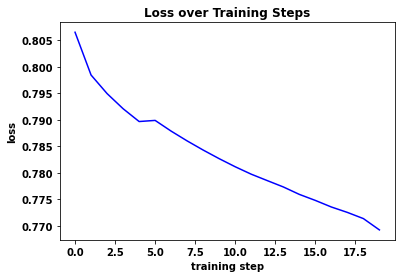

In [25]:
plt.plot(losses, color='blue')
plt.title("Loss over Training Steps", fontweight="bold")
plt.xlabel("training step")
plt.ylabel("loss")
plt.show()

Shapelets:

Type and shape of the shapelets in output <class 'numpy.ndarray'> (3, 38, 1)


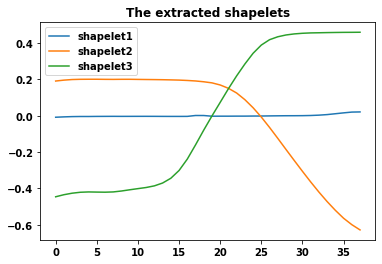

In [32]:
# plot the shapelets
S = extractor.get_shapelets()
# use moveaxis because the shapelets returned have shape (num_shapelets, in_channels, shapelets_size)
S = np.moveaxis(S, 1, 2)
print('Type and shape of the shapelets in output', type(S),  S.shape)

plt.figure()
for i in range(len(S)):
    shap = S[i,:,]
    plt.plot(shap, label=f'shapelet{i+1}')
plt.legend()
plt.title('The extracted shapelets', fontweight="bold")
plt.show()


Transform train and test set:

In [33]:
# tranform method takes in input a tensor of shape (n_samples, in_channels, len_ts) 
# and outputs a numpy array of shape (n_samples, n_shapelets)
X_train_transform = extractor.transform(X_train_tensor)
X_valid_tensor = tensor(X_valid_anomaly, dtype=torch.float).contiguous().transpose(1,2)
X_valid_transform = extractor.transform(X_valid_tensor)
X_test_tensor = tensor(X_test_anomaly, dtype=torch.float).contiguous().transpose(1,2)
X_test_transform = extractor.transform(X_test_tensor)

# check if type and shape are correct:
print('Type and shape of transformed train data', type(X_train_transform),  X_train_transform.shape)
print('Type and shape of transformed test data', type(X_test_transform),  X_test_transform.shape)

Type and shape of transformed train data <class 'numpy.ndarray'> (84, 3)
Type and shape of transformed test data <class 'numpy.ndarray'> (81, 3)


## Anomaly detection using SVDD

Choose how many extracted shapelets to take (2 for visualization purposes):

13 support vectors out of 84 points
Solution found with center in 0.0 and radius 0.406049907207489
Test balanced accuracy: 0.6195652173913044
Test F1 score: 0.5656565656565656


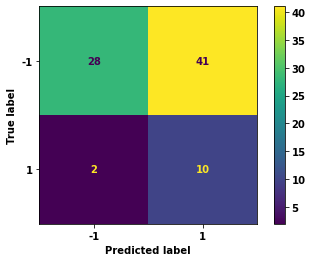

Test AUC: 0.6280193236714976
valid balanced accuracy: 0.6967592592592593
valid F1 score: 0.6666666666666667
Valid AUC: 0.8287037037037037


In [34]:
svdd = SVDD(C=C, zero_center=True, tol=1e-6, verbose=True, show_progress=False)

# fit the model
svdd.fit(X_train_transform)

# BALANCED ACCURACY
y_test_predict = svdd.predict(X_test_transform)
test_ba = balanced_accuracy_score(y_test_anomaly, y_test_predict)
print("Test balanced accuracy:", test_ba)
# F1 score
f1_test = f1_score(y_test_anomaly, y_test_predict, pos_label=-1)
print("Test F1 score:", f1_test)

# Confusion matrix for test 
cm = confusion_matrix(y_test_anomaly, y_test_predict)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[-1,1]).plot()
plt.show()

# AUC
y_test_scores = -svdd.decision_function(X_test_transform)
fpr, tpr, _ = roc_curve(y_test_anomaly, y_test_scores, pos_label=-1)
auc_test = auc(fpr, tpr)
print("Test AUC:", auc_test)

y_valid_predict = svdd.predict(X_valid_transform)
valid_ba = balanced_accuracy_score(y_valid_anomaly, y_valid_predict)
print("valid balanced accuracy:", valid_ba)
# F1 score
f1_valid = f1_score(y_valid_anomaly, y_valid_predict, pos_label=-1)
print("valid F1 score:", f1_valid)

y_valid_scores = -svdd.decision_function(X_valid_transform)
fpr, tpr, _ = roc_curve(y_valid_anomaly, y_valid_scores, pos_label=-1)
auc_valid = auc(fpr, tpr)
print("Valid AUC:", auc_valid)

EVALUATE the prediction:

In [35]:
## TRAIN
# BALANCED ACCURACY
y_train_predict = svdd.predict(X_train_transform)
train_ba = balanced_accuracy_score(y_train_anomaly, y_train_predict)
print("SVDD train balanced accuracy:", train_ba)

# AUC
y_train_scores = svdd.decision_function(X_train_transform)
auc_train = roc_auc_score(y_train_anomaly, y_train_scores)
print("SVDD train AUC:", auc_train)

# F1 score
f1_train = f1_score(y_train_anomaly, y_train_predict)
print("SVDD train F1 score:", f1_train)

SVDD train balanced accuracy: 0.81875
SVDD train AUC: 0.9125
SVDD train F1 score: 0.9342105263157895


In [36]:
## TEST
# BALANCED ACCURACY
y_test_predict = svdd.predict(X_test_transform)
test_ba = balanced_accuracy_score(y_test_anomaly, y_test_predict)
print("SVDD test balanced accuracy:", test_ba)

# AUC
y_test_scores = svdd.decision_function(X_test_transform)
auc_test = roc_auc_score(y_test_anomaly, y_test_scores)
print("SVDD test AUC:", auc_test)

# F1 score
f1_train = f1_score(y_train_anomaly, y_train_predict)
print("SVDD train F1 score:", f1_train)

SVDD test balanced accuracy: 0.6195652173913044
SVDD test AUC: 0.6280193236714976
SVDD train F1 score: 0.9342105263157895


### PLOTS (first two coordinates in shapelet transformed space):

NOTE: if were taken more than 2 shapelets the SVDD boundaries are plotted but they do not indicate the correct boundary in more than two dimension of the true points (the points are collapsed in the plane as if their other coordinates were equal to zero)

TRAIN DATA and SVDD boundary

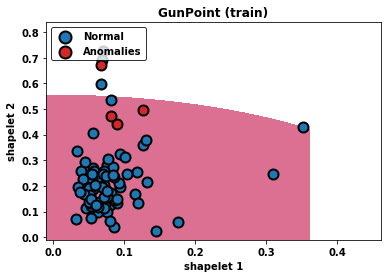

In [40]:
x_max = max(X_train_transform[:,0])+0.01
y_max = max(X_train_transform[:,1])+0.01
xx, yy = np.meshgrid(np.linspace(-0.1, x_max, 500), np.linspace(-0.1, y_max, 500))
Z = svdd.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
pIndex_train = y_train_anomaly == 1
nIndex_train = y_train_anomaly == -1


plt.figure()
plt.title(f"{data_name} (train)", fontweight="bold")

plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors="palevioletred")
plt.scatter(X_train_transform[pIndex_train, 0], X_train_transform[pIndex_train, 1], facecolor='C0', marker='o', s=100, linewidths=2,
                     edgecolor='black', zorder=2, label="Normal")

plt.scatter(X_train_transform[nIndex_train, 0], X_train_transform[nIndex_train, 1], facecolor='C3', marker='o', s=100, linewidths=2,
                     edgecolor='black', zorder=2, label="Anomalies")

plt.legend(ncol=1, loc='upper left', edgecolor='black',
                    markerscale=1.2, fancybox=True)
plt.xlim((-0.01, x_max + 0.1))
plt.ylim((-0.01, y_max + 0.1))
plt.ylabel("shapelet 2")
plt.xlabel("shapelet 1")
plt.show()

TEST DATA and SVDD boundary

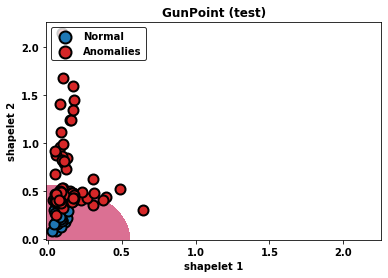

In [41]:
x_max = max(X_test_transform[:,0])+0.01
y_max = max(X_test_transform[:,1])+0.01
xx, yy = np.meshgrid(np.linspace(-0.1, x_max, 500), np.linspace(-0.1, y_max, 500))
Z = svdd.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
pIndex_test = y_test_anomaly == 1
nIndex_test = y_test_anomaly == -1
auc_test = np.around(auc_test, 3)
plt.figure()
plt.title(f"{data_name} (test)", fontweight="bold")

plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors="palevioletred")
plt.scatter(X_test_transform[pIndex_test, 0], X_test_transform[pIndex_test, 1], facecolor='C0', marker='o', s=100, linewidths=2,
                     edgecolor='black', zorder=2, label="Normal")

plt.scatter(X_test_transform[nIndex_test, 0], X_test_transform[nIndex_test, 1], facecolor='C3', marker='o', s=100, linewidths=2,
                     edgecolor='black', zorder=2, label="Anomalies")

plt.legend(ncol=1, loc='upper left', edgecolor='black',
                     markerscale=1.2, fancybox=True)

plt.xlim((-0.01, y_max + 0.1))
plt.ylim((-0.01, y_max + 0.1))
plt.ylabel("shapelet 2")
plt.xlabel("shapelet 1")
plt.show()